##Prepare dataset and code

In [1]:
#mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
#set myDrive as current path
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [3]:
#get data and other code from github
!git clone https://github.com/ShengfangM/finalProject.git 

Cloning into 'finalProject'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 45 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [4]:
#copy all data to google drive to run the code
!unzip '/content/drive/MyDrive/finalProject/RGB.zip' -d '/content/drive/MyDrive/finalProject/'

Archive:  /content/drive/MyDrive/finalProject/RGB.zip
   creating: /content/drive/MyDrive/finalProject/RGB/
   creating: /content/drive/MyDrive/finalProject/RGB/test/
   creating: /content/drive/MyDrive/finalProject/RGB/test/Images/
  inflating: /content/drive/MyDrive/finalProject/RGB/test/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1025.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/test/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1026.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/test/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1029.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/test/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1030.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/test/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1031.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/test/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1058.png  

## Install more packages


In [2]:
#install all required package to run the code
!pip install gdal
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-fmxkelsg
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-fmxkelsg
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=304481 sha256=98948ae57c63f5cd37fbe8a4012df33bf8205e424ba74f9678a5d29f95b052c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ny2tdxh/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [3]:
#change the current path 
# there are many cited code files here
%cd /content/drive/MyDrive/finalProject

/content/drive/MyDrive/finalProject


##import needed library

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from osgeo import gdal, gdalnumeric
from gdalRW import getMeta, getAllData

import torch
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator


In [5]:
# pretrained weights
model_urls = {
    'ssd300_vgg16_coco': 'https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth',
    'ssd320_lite_coco': "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth",
    'ssd300_res50_coco': 'https://api.ngc.nvidia.com/v2/models/nvidia/ssd_pyt_ckpt_amp/versions/20.06.0/files/nvidia_ssdpyt_amp_200703.pt',
    'fasterrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth',
    'fasterrcnn_mobilenet_v3_large_320_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth',
    'fasterrcnn_mobilenet_v3_large_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth'
}

# Start Training
the following code are referred from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# SSD Model

###Prepare dataset for training

Define batchsize here


In [6]:
from peanutDataset import peanutDroneDataset,get_transform
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.cuda.empty_cache() 

root = '/content/drive/MyDrive/finalProject/RGB/train'
valid_root = "/content/drive/MyDrive/finalProject/RGB/test"

# # our dataset has two classes only - background and person
num_classes = 2
# # # use our dataset and defined transformations
# dataset = peanutDroneDataset(root, get_transform(train=True),target_transforms = None)
# dataset_test = peanutDroneDataset(valid_root, get_transform(train=False),target_transforms = None)

# cross validation
dataset = peanutDroneDataset(root, get_transform(train=True),target_transforms = None)
dataset_test = peanutDroneDataset(root, get_transform(train=False),target_transforms = None)
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[101:])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:101])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=6, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


cuda


## Get the model

In [7]:
# library for this function
from resnetssd import ResNet, res_extractor
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

# function tu build ssd model with backbone 
#
def custom_ssd_model(backbone, num_classes):

  if(backbone == 'resnet50'):
  # Use custom backbones more appropriate for SSD
    backbone=ResNet('resnet50')
    backbone=res_extractor(backbone)
    #   backbone = vgg16(weights=weights_backbone, progress=progress)
    # backbone = _res_extractor(backbone, False, trainable_backbone_layers)

    anchor_generator = torchvision.models.detection.anchor_utils.DefaultBoxGenerator(
            [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
            scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
            steps=[8, 16, 32, 64, 100, 300],
        )

    model = torchvision.models.detection.ssd.SSD(backbone,anchor_generator, (300,300), num_classes=num_classes)
    mstate_dict = model.state_dict()

    # get pretrained weights from NVIDIA_SSD
    ssd_model2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
    cstate_dict= ssd_model2.state_dict()
    # Step 3.
    # Step 3.
    i = 0
    ck = []
    for cki in cstate_dict.keys():
      ck.append(cki)

    for k in mstate_dict.keys():
      cki = ck[i]
      i += 1

      if mstate_dict[k].shape == cstate_dict[cki].shape:

        mstate_dict[k] = cstate_dict[cki]
        
    model.load_state_dict(mstate_dict, strict=False)

  elif (backbone == 'mobilenet_v3'):
        
      #     num_classes = 2
      # Step 1.
      model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes)
      # Step 2, load the model state_dict and the default model's state_dict
      progress=True
      mstate_dict = model.state_dict()
      #     cstate_dict = torch.load(args.weights)
      # cstate_dict = torchvision._internally_replaced_utils.load_state_dict_from_url(model_urls['ssd320_lite_coco'],
      #                                           progress=progress)
      
      model2 = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
      cstate_dict = model2.state_dict()
      # # Step 3.
      for k in mstate_dict.keys():

        # print('key {} orishape: {}, training shape: {}'.format(k, cstate_dict[k].shape, mstate_dict[k].shape))

        if mstate_dict[k].shape != cstate_dict[k].shape:
            print('key {} will be removed'.format(k))
            # # cstate_dict.pop(k)
            # tt = cstate_dict[k].shape[0]              
            # mstate_dict[k][:tt] = cstate_dict[k]
            # mstate_dict[k][tt:] = cstate_dict[k]
        else:
          mstate_dict[k]= cstate_dict[k]
      # Step 4.
      model.load_state_dict(mstate_dict, strict=False)
    
  elif(backbone == 'vgg16'):

      model = torchvision.models.detection.ssd300_vgg16(pretrained=False, num_classes=num_classes)
       # Step 2, load the model state_dict and the default model's state_dict
      progress=True
      mstate_dict = model.state_dict()
      #     cstate_dict = torch.load(args.weights)
      cstate_dict = torchvision._internally_replaced_utils.load_state_dict_from_url(model_urls['ssd300_vgg16_coco'],
                                                progress=progress)
            # # Step 3.
      for k in mstate_dict.keys():

        if mstate_dict[k].shape != cstate_dict[k].shape:
            print('key {} will be removed'.format(k))
            cstate_dict.pop(k)
            # tt = cstate_dict[k].shape[0]              
            # mstate_dict[k][:tt] = cstate_dict[k]
            # mstate_dict[k][tt:] = cstate_dict[k]

      # Step 4.
      model.load_state_dict(cstate_dict, strict=False)

  return model

## Train the model

> First get ssd model.
There are three backbone models available here: resnet50, vgg16, and mobilenet_v3

In [8]:
backbone = 'resnet50' 
# backbone = 'vgg16' 
# backbone = 'mobilenet_v3'
#load the ssd model
ssd_model = custom_ssd_model(backbone, num_classes)

# move model to the right device
ssd_model.to(device)

# construct an optimizer
params = [p for p in ssd_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00075,
                            momentum=0.9, weight_decay=0.000075)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

In [9]:
from engine import train_one_epoch, evaluate

# let's train it for 10 epochs
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(ssd_model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
    if (epoch)%5 ==0:
        torch.save(ssd_model, 'ssd_model_' +backbone+'_rgb_{}.pth'.format(epoch))
           
    # evaluate on the test dataset
    evaluate(ssd_model, data_loader_test, device=device)

print("Training process ended!")

Epoch: [0]  [  0/100]  eta: 0:06:03  lr: 0.000008  loss: 12.5574 (12.5574)  bbox_regression: 3.3986 (3.3986)  classification: 9.1587 (9.1587)  time: 3.6385  data: 0.0522  max mem: 1569
Epoch: [0]  [ 10/100]  eta: 0:00:55  lr: 0.000084  loss: 11.3111 (11.2754)  bbox_regression: 3.1499 (3.1938)  classification: 8.1611 (8.0816)  time: 0.6124  data: 0.0937  max mem: 1674
Epoch: [0]  [ 20/100]  eta: 0:00:34  lr: 0.000160  loss: 10.0224 (10.2002)  bbox_regression: 3.0540 (3.0773)  classification: 6.7110 (7.1229)  time: 0.2751  data: 0.0653  max mem: 1674
Epoch: [0]  [ 30/100]  eta: 0:00:26  lr: 0.000235  loss: 8.1126 (9.3332)  bbox_regression: 2.7854 (2.9645)  classification: 5.1996 (6.3687)  time: 0.2417  data: 0.0339  max mem: 1674
Epoch: [0]  [ 40/100]  eta: 0:00:20  lr: 0.000311  loss: 6.5427 (8.5186)  bbox_regression: 2.5721 (2.8315)  classification: 4.0320 (5.6871)  time: 0.2429  data: 0.0344  max mem: 1674
Epoch: [0]  [ 50/100]  eta: 0:00:16  lr: 0.000387  loss: 5.5107 (7.8741)  bbox_

#Faster RCNN model

### Prepare dataset

In [6]:
from peanutDataset import peanutDroneDataset,get_transform
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.cuda.empty_cache() 

root = '/content/drive/MyDrive/finalProject/RGB/train'
valid_root = "/content/drive/MyDrive/finalProject/RGB/test"

# # our dataset has two classes only - background and person
num_classes = 2
# # # use our dataset and defined transformations
# dataset = peanutDroneDataset(root, get_transform(train=True),target_transforms = None)
# dataset_test = peanutDroneDataset(valid_root, get_transform(train=False),target_transforms = None)

# cross validation
dataset = peanutDroneDataset(root, get_transform(train=True),target_transforms = None)
dataset_test = peanutDroneDataset(root, get_transform(train=False),target_transforms = None)
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[101:])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:101])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=6, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


cpu


##Get Faster RCNN model

In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#get pretrained faster rcnn
def get_FasterRCNN(backbone, num_classes, pret=True):
  # load a model pre-trained pre-trained on COCO
  if backbone == 'resnet50':
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pret)
  elif  backbone == 'mobilenet_v3':
  #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pret)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=pret)
  else:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pret)    

  # replace the classifier with a new one, that has
  # num_classes which is user-defined
  num_classes = 2  # 1 class (person) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

  return model

##Train Faster RCNN model

In [8]:

backbone = 'resnet50' 
# backbone = 'vgg16' 
# backbone = 'mobilenet_v3'
# get the faster RCNN model based on the backbone
FRCNNmodel = get_FasterRCNN(backbone, num_classes)

# move model to the right device
FRCNNmodel.to(device)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:

# construct an optimizer
params = [p for p in FRCNNmodel.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00075,
                            momentum=0.9, weight_decay=0.000075)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from engine import train_one_epoch, evaluate
# let's train it for 10 epochs
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(FRCNNmodel, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
    if (epoch)%5 ==0:
        torch.save(FRCNNmodel, 'FasterRCNN_'+backbone+'_rgb_{}.pth'.format(epoch))
           
    # evaluate on the test dataset
    evaluate(FRCNNmodel, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/100]  eta: 0:02:10  lr: 0.000008  loss: 2.1297 (2.1297)  loss_classifier: 1.0451 (1.0451)  loss_box_reg: 0.6706 (0.6706)  loss_objectness: 0.3841 (0.3841)  loss_rpn_box_reg: 0.0299 (0.0299)  time: 1.3045  data: 0.0855  max mem: 7011
Epoch: [0]  [ 10/100]  eta: 0:01:53  lr: 0.000084  loss: 1.9886 (2.0220)  loss_classifier: 1.0470 (1.0429)  loss_box_reg: 0.6488 (0.6601)  loss_objectness: 0.2609 (0.2959)  loss_rpn_box_reg: 0.0247 (0.0232)  time: 1.2621  data: 0.0373  max mem: 7279
Epoch: [0]  [ 20/100]  eta: 0:01:42  lr: 0.000160  loss: 1.9886 (2.0091)  loss_classifier: 1.0407 (1.0415)  loss_box_reg: 0.6614 (0.6641)  loss_objectness: 0.2609 (0.2809)  loss_rpn_box_reg: 0.0206 (0.0226)  time: 1.2808  data: 0.0322  max mem: 7279
Epoch: [0]  [ 30/100]  eta: 0:01:30  lr: 0.000235  loss: 2.0660 (2.0455)  loss_classifier: 1.0311 (1.0353)  loss_box_reg: 0.6833 (0.6811)  loss_objectness: 0.2986 (0.3052)  loss_rpn_box_reg: 0.0238 (0.0239)  time: 1.3009  data: 0.0324  max mem: 7279


# Evaluate models

In [10]:
# get the trained model 
checkpoints = ["FasterRCNN_resnet50_rgb_5.pth", "FasterRCNN_mobilenet_v3_rgb_5.pth","ssd_model_resnet50_rgb_5.pth","ssd_model_mobilenet_v3_rgb_5.pth"]
# choose the model to load
model = torch.load(checkpoints[0])

RuntimeError: ignored

In [11]:
test_root = '/content/drive/MyDrive/finalProject/RGB/test'

dataset_test2 = peanutDroneDataset(test_root, get_transform(train=False),target_transforms = None)

data_loader_test2 = torch.utils.data.DataLoader(
    dataset_test2, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# evaluate on the test dataset
evaluate(model, data_loader_test2, device=device)

NameError: ignored

## Calculate Precision, Recall and F1 at given confidence score threshold

In [13]:
# get ground truth boxes
from peanutDataset import filtermasks

def get_box_gt(mask_path):

        #mask = Image.open(mask_path)
    mask = getAllData(mask_path)
    #filter ... 
    mask = filtermasks(mask)

    obj_ids = np.unique(mask)
    #print(obj_ids)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]        
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        #pos = np.where(mask==i)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        boxes.append([xmin, ymin, xmax, ymax])
        
    return boxes


In [14]:
from accuracymetrics import metrix_box

preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float)
    ])


model.eval()


TP50=0
FP50=0
FN50 = 0

TP75=0
FP75=0
FN75 = 0

TP95=0
FP95=0
FN95 = 0

testpath = '/content/drive/MyDrive/finalProject/RGB/test/Images'
testmask = '/content/drive/MyDrive/finalProject/RGB/test/Masks'
testfile_list = sorted(os.listdir(testpath))
testmask_list =  sorted(os.listdir(testmask))
for filein in range(len(testfile_list)):
    
    testfile = testfile_list[filein]   
    testimg =  Image.open(os.path.join(testpath,testfile)).convert("RGB")

    #
    # Pass the image for preprocessing and the image preprocessed
    #
    img_preprocessed = preprocess(testimg)
    #
    # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
    #
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
    batch_img_cat_tensor = batch_img_tensor.cuda()

    output = model(batch_img_cat_tensor)


    score_threshold = 0.65
    for outputi in output:

        box_lables = get_box_gt(os.path.join(testmask,testmask_list[filein]))
        aaa = metrix_box(outputi, box_lables, score_threshold)

        TP50 += aaa[0]
        FP50 += aaa[1]
        FN50 += aaa[2]

        TP75 += aaa[3]
        FP75 += aaa[4]
        FN75 += aaa[5]

        TP95 += aaa[6]
        FP95 += aaa[7]
        FN95 += aaa[8]
AP50 =  TP50/(TP50+FP50)      
AR50 =  TP50/(TP50+FN50)  

AP75 =  TP75/(TP75+FP75)      
AR75 =  TP75/(TP75+FN75)

AP95 =  TP95/(TP95+FP95)      
AR95 =  TP95/(TP95+FN95)  

print(AP50, AR50, AP50*AR50, AP75, AR75, AP75*AR75, AP95, AR95)

0.7883008356545961 0.8610547667342799 0.6787701921610062 0.6220984215413184 0.6795131845841785 0.422724079546332 0.01021355617455896 0.011156186612576065


### visulize the prediction

In [22]:
# get the trained model 
checkpoints = ["FasterRCNN_resnet50_rgb_5.pth", "FasterRCNN_mobilenet_v3_rgb_5.pth","ssd_model_resnet50_rgb_5.pth","ssd_model_mobilenet_v3_rgb_5.pth"]
# choose the model to load
model = torch.load(checkpoints[0])

In [15]:
from matplotlib.patches import Rectangle

def show_box(imgi, target, threshold):

    boxes = target["boxes"]
    labels = target["labels"] 
    scores = target["scores"] 
    #masks = target[l]["masks"] 
    boxes = boxes.cpu().data.numpy()
    scores = scores.cpu().data.numpy()
    labels = labels.cpu().data.numpy()
    #imgi = img.permute(1,2,0) 

    N = len(boxes)
    print(N)
    area = np.zeros(N)
    for i in range(N):
        area[i] = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1])

    mean_area = np.mean(area)
    devia = np.sqrt(np.sum((area - mean_area)**2)/(N-1))
    upperbound = mean_area+1.2*devia
    lowerbound = mean_area-1.2*devia
    
    #boxes=outputi['boxes'][area(outputi['boxes']) > upperbound]
    
    fig = plt.gcf()
    fig.set_size_inches(18.5,10.5)

    plt.imshow(imgi)

    ax = plt.gca()

    for i in range(len(boxes)):
        if lowerbound<(boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) < upperbound and 0.4<(boxes[i][2] - boxes[i][0])/(boxes[i][3] - boxes[i][1])<2.5:
            if(scores[i]>threshold):

                ax.add_patch(Rectangle((boxes[i][0],boxes[i][1]),
                                       (boxes[i][2] - boxes[i][0]),
                                       (boxes[i][3] - boxes[i][1]),
                                      fill = False,
                                      edgecolor = 'red',
                                      linewidth=3))
                sss=round(scores[i],3)
                aaa= str(sss)
                ax.text(boxes[i][0],boxes[i][1]-1, aaa, fontsize=24, color = 'red')

    fig = plt.gcf
    plt.tick_params(labelbottom='on')
    plt.show()

18


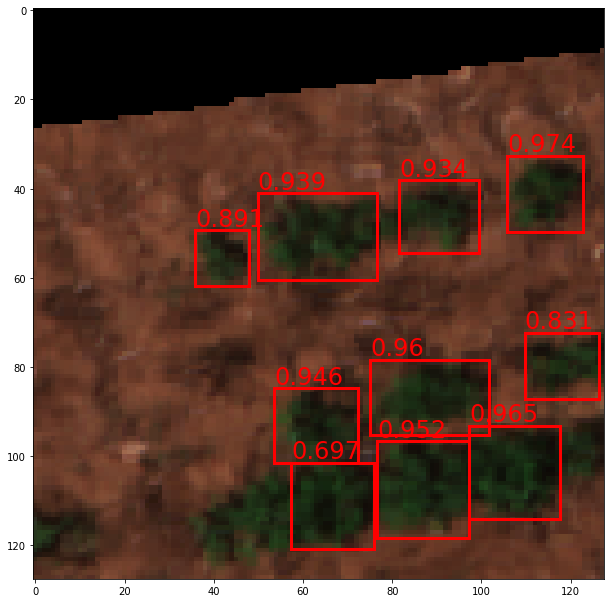

071219_Composit_Peanut_blue_green_red_8bit_dataclip_394.png
15


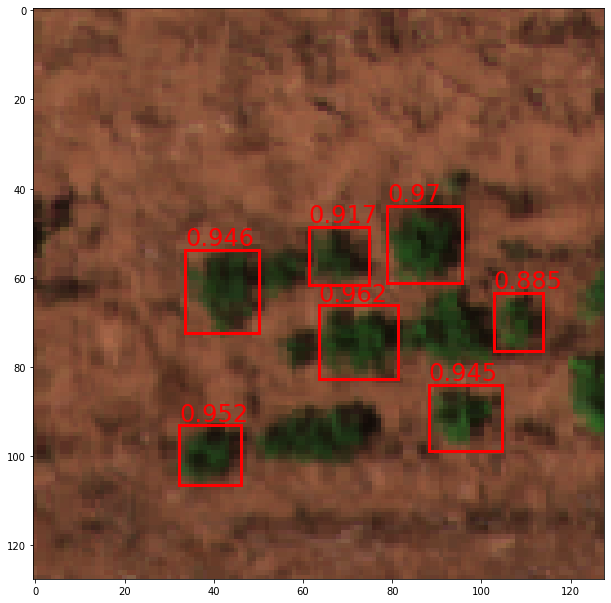

071219_Composit_Peanut_blue_green_red_8bit_dataclip_2824.png
21


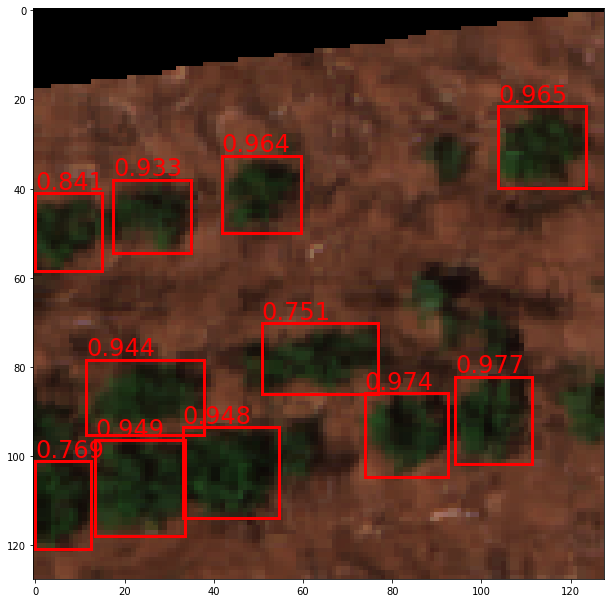

071219_Composit_Peanut_blue_green_red_8bit_dataclip_429.png
16


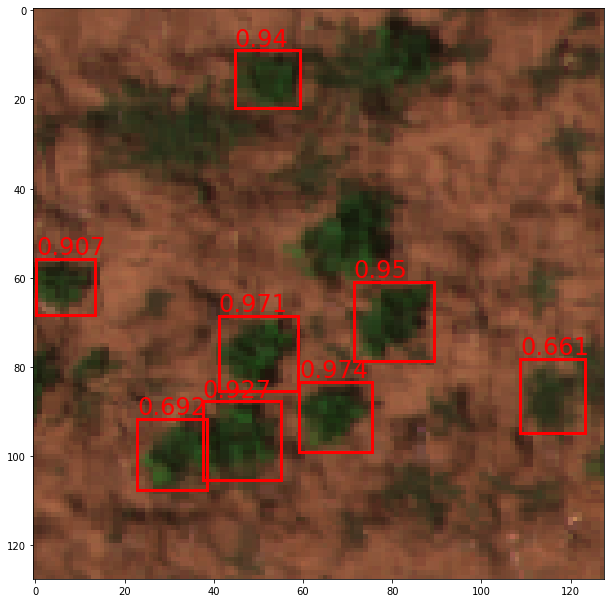

071219_Composit_Peanut_blue_green_red_8bit_dataclip_3837.png
15


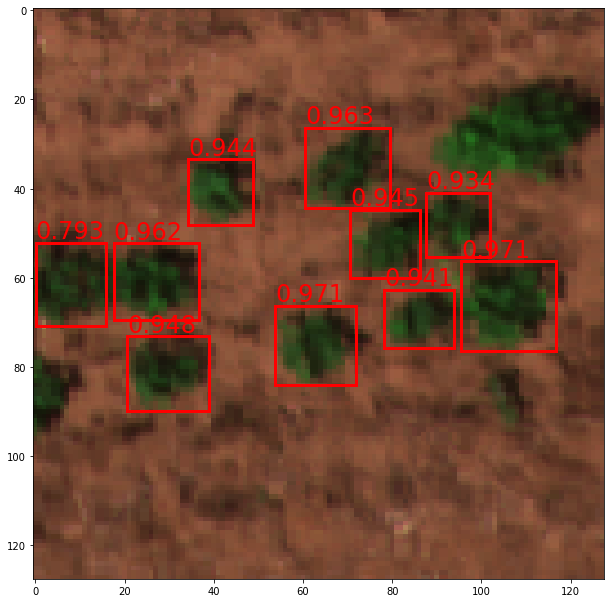

071219_Composit_Peanut_blue_green_red_8bit_dataclip_2894.png
19


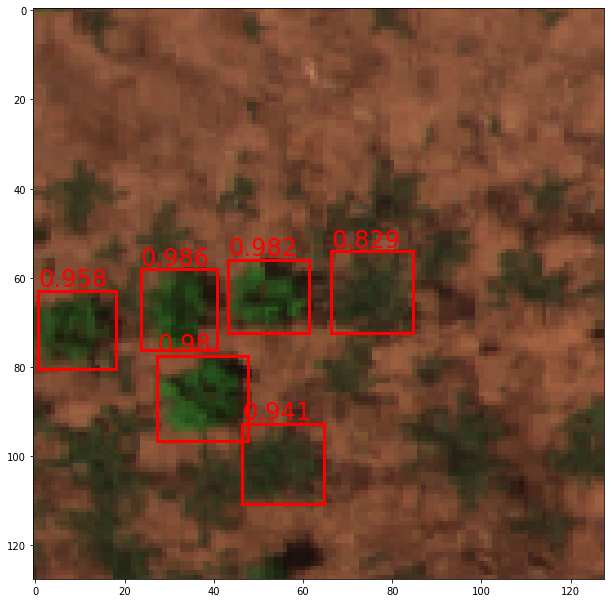

071219_Composit_Peanut_blue_green_red_8bit_dataclip_3869.png
6


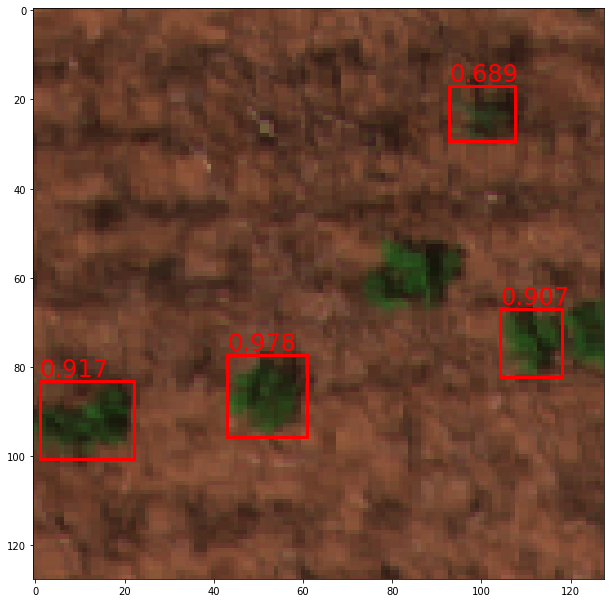

071219_Composit_Peanut_blue_green_red_8bit_dataclip_2892.png
21


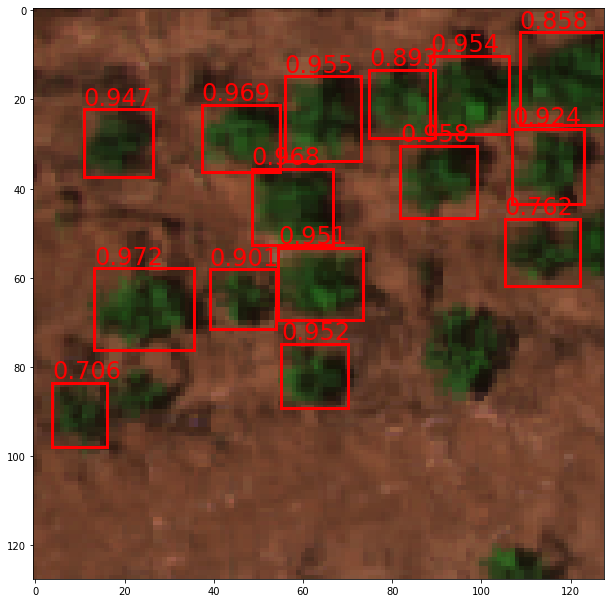

071219_Composit_Peanut_blue_green_red_8bit_dataclip_3280.png


In [21]:
# import random 
from random import sample

preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float)
    ])


model.eval()

testpath = '/content/drive/MyDrive/finalProject/RGB/test/Images'
# testfile_list = os.listdir(testpath)
# for testfile in sample(testfile_list,10):
testfile_list=['071219_Composit_Peanut_blue_green_red_8bit_dataclip_394.png',
  '071219_Composit_Peanut_blue_green_red_8bit_dataclip_2824.png',
'071219_Composit_Peanut_blue_green_red_8bit_dataclip_429.png',
  '071219_Composit_Peanut_blue_green_red_8bit_dataclip_3837.png',
'071219_Composit_Peanut_blue_green_red_8bit_dataclip_2894.png',
  '071219_Composit_Peanut_blue_green_red_8bit_dataclip_3869.png',
'071219_Composit_Peanut_blue_green_red_8bit_dataclip_2892.png',
  '071219_Composit_Peanut_blue_green_red_8bit_dataclip_3280.png',]
for testfile in testfile_list:   
    testimg =  Image.open(os.path.join(testpath,testfile)).convert("RGB")

    #
    # Pass the image for preprocessing and the image preprocessed
    #
    img_preprocessed = preprocess(testimg)
    #
    # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
    #
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
    batch_img_cat_tensor = batch_img_tensor.cuda()

    output = model(batch_img_cat_tensor)


    score_threshold = 0.65
    for outputi in output:

        show_box(testimg,outputi, score_threshold)
        print(testfile)
